<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/Kaggle_%EC%A7%91%EA%B0%92_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [ ]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [ ]:
data = pd.concat([train, test])
data = data.reset_index(drop=True)

In [ ]:
def missing_data(df):
    total = df.isnull().sum()
    percent = round(df.isnull().sum()/len(df)*100, 2)
    
    table = pd.concat([total, percent], axis=1, keys=['total', 'percent']).sort_values(by='total', ascending=False)
    return table

missing_data(data).head(30)

,total,percent
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
SalePrice,1459,49.98
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageFinish,159,5.45
GarageQual,159,5.45
GarageCond,159,5.45


# 순서형 변수(결측값이 많은) ==> 다른 인코딩 방법

In [ ]:
data['PoolQC'] = data['PoolQC'].fillna('NaN')  # pool 품질
data['Fence'] = data['Fence'].fillna('NaN')  # 펜스 품질
data['FireplaceQu'] = data['FireplaceQu'].fillna('NaN')  # 벽난로 품질

# 명목형 변수(결측값이 많은) ==> 레이블 인코딩

In [ ]:
data['MiscFeature'] = data['MiscFeature'].fillna('NaN')  # 기타 범주에서 다루지 않는 기타 기능
data['Alley'] = data['Alley'].fillna('NaN')  # 골목길 포장 유형(?)

# 'Garage' 관련 변수 처리

In [ ]:
garage_col = [col for col in data.columns if col.find('Garage') != -1]

for i in garage_col:
    if data[i].dtype == 'object':
        data[i] = data[i].fillna('NaN')
    else:
        data[i] = data[i].fillna(0)

# Exterior 변수 처리

In [ ]:
data['Exterior1st'] = data['Exterior1st'].fillna('NaN')

# BsmtFinType 변수 처리

In [ ]:
data.loc[(data['BsmtFinType2'].isnull())&(data['BsmtFinType1'].notnull()), 'BsmtFinType2'] = 'Rec'

In [ ]:
data['BsmtFinType1'] = data['BsmtFinType1'].fillna('NaN')
data['BsmtFinType2'] = data['BsmtFinType2'].fillna('NaN')

In [ ]:
data['BsmtCond'] = data['BsmtCond'].fillna('NaN')
data['BsmtQual'] = data['BsmtQual'].fillna('NaN')
data['BsmtExposure'] = data['BsmtExposure'].fillna('NaN')

# 결측치 처리(마지막)

In [ ]:
for i in data.select_dtypes('object').columns:
    data[i] = data[i].fillna('NaN')
    
for i in data.select_dtypes('float').columns:
    if i in ['SalePrice', 'LotFrontage']:
        continue
    data[i] = data[i].fillna(0)

In [ ]:
data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].median())

# aggregation
카테고리변수는 count, sum, mean
숫자형변수는 sum, median, min, max, count

* 카테고리변수를 agg해봤자 성능만 떨어질듯

In [ ]:
numeric_columns = []
for i in data.columns:
    if data[i].dtypes=='object':
        continue
    elif i == 'SalePrice':
        continue
    else:
        numeric_columns.append(i)
numeric_columns

In [ ]:
data_numeric = data[numeric_columns]
data_numeric_agg = data_numeric.groupby('Id').agg(['count', 'mean', 'max', 'min', 'sum'])
data_numeric_col = []
for i in data_numeric_agg.columns.levels[0]:
    for j in data_numeric_agg.columns.levels[1]:
        data_numeric_col.append(f'{i}-{j}')
                                
data_numeric_agg.columns = data_numeric_col

In [ ]:
corr_matrix = data_numeric_agg.corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [c for c in upper.columns if any(abs(upper[c])>0.8)]

print(f'{len(data_numeric_agg.columns)}There are {len(to_drop)} corr columns to remove')

In [ ]:
data_numeric_agg = data_numeric_agg.drop(columns = to_drop)

In [ ]:
data = data.merge(data_numeric_agg, on = 'Id', how='left')

# Feature Cons

In [ ]:
data["SqFtPerRoom"] = data["GrLivArea"] / (data["TotRmsAbvGrd"] +
                                                       data["FullBath"] +
                                                       data["HalfBath"] +
                                                       data["KitchenAbvGr"])

data['Total_Home_Quality'] = data['OverallQual'] + data['OverallCond']

data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) +
                               data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

data["HighQualSF"] = data["1stFlrSF"] + data["2ndFlrSF"]
# Converting non-numeric predictors stored as numbers into string

data['MSSubClass'] = data['MSSubClass'].apply(str)
data['YrSold'] = data['YrSold'].apply(str)
data['MoSold'] = data['MoSold'].apply(str)


data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# log변환

In [ ]:
from scipy.stats import skew

In [ ]:
numeric_features = data.dtypes[data.dtypes != object].index
skewed_features = data[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index
# Normalize skewed features using log_transformation
for i in skew_index:
    data[i] = np.log1p(data[i])

# catboost 돌리는 Ver.

In [ ]:
x_train = data.loc[data['SalePrice'].notnull()].drop(columns=['Id', 'SalePrice'])
y_train = data.loc[data['SalePrice'].notnull()]['SalePrice']
x_test = data.loc[data['SalePrice'].isnull()].drop(columns=['Id', 'SalePrice'])

x_train.shape, y_train.shape, x_test.shape

((1460, 88), (1460,), (1459, 88))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
numeric_col = [col for col in x_train.columns if x_train[col].dtype!='object']

data_col = x_train.columns
x_train[numeric_col] = MinMaxScaler().fit_transform(x_train[numeric_col])
x_test[numeric_col] = MinMaxScaler().fit_transform(x_test[numeric_col])

x_train.shape, x_test.shape

((1460, 79), (1459, 79))

In [ ]:
import catboost
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
cat_features = x_train.select_dtypes('object').columns
preds_cat = np.zeros((len(x_test)))
params = {'iterations': 6000,
          'learning_rate': 0.005,
          'depth': 4,
          'l2_leaf_reg': 1,
          'eval_metric':'RMSE',
          'random_seed': 42}

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
    X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
    Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    model=catboost.CatBoostRegressor(n_estimators=5000, eval_metric='RMSE', use_best_model=True )
    
    model.fit(X_train, Y_train, cat_features=cat_features, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=50)
    
    preds_cat_valid = model.predict(X_valid)
    print(f'{i+1}Fold RMSE:{np.sqrt(mean_squared_error(preds_cat_valid, Y_valid))}')
    preds_cat = model.predict(x_test) / skf.n_splits

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Learning rate set to 0.017409
0:	learn: 79297.3705139	test: 79297.3705139	test1: 75180.7783233	best: 75180.7783233 (0)	total: 28ms	remaining: 2m 19s
100:	learn: 34394.8609369	test: 34163.4594200	test1: 35988.7080690	best: 35988.7080690 (100)	total: 2.84s	remaining: 2m 17s
200:	learn: 23985.9161306	test: 23769.0955555	test1: 29974.1208964	best: 29967.7643573 (199)	total: 5.9s	remaining: 2m 20s
300:	learn: 20531.6108234	test: 20510.7639704	test1: 28975.1066141	best: 28975.1066141 (300)	total: 8.63s	remaining: 2m 14s
400:	learn: 18625.9526838	test: 18748.1640952	test1: 28616.4447834	best: 28616.4447834 (400)	total: 11.4s	remaining: 2m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 28616.44478
bestIteration = 400

Shrink model to first 401 iterations.
1Fold RMSE:28616.44478341241
Learning rate set to 0.017409
0:	learn: 79547.8061914	test: 79542.3402097	test1: 74104.7137549	best: 74104.7137549 (0)	total: 28.4ms	remaining: 2m 21s
100:	learn: 34737.6288918	test: 34451.2

In [ ]:
valid_index = Y_valid.index

In [ ]:
preds_cat_Frame = pd.DataFrame(preds_cat_valid, index=valid_index).rename(columns={0:'SalePrice_preds'})

Text(0.5, 1.0, 'Val-Preds vs Val-y')

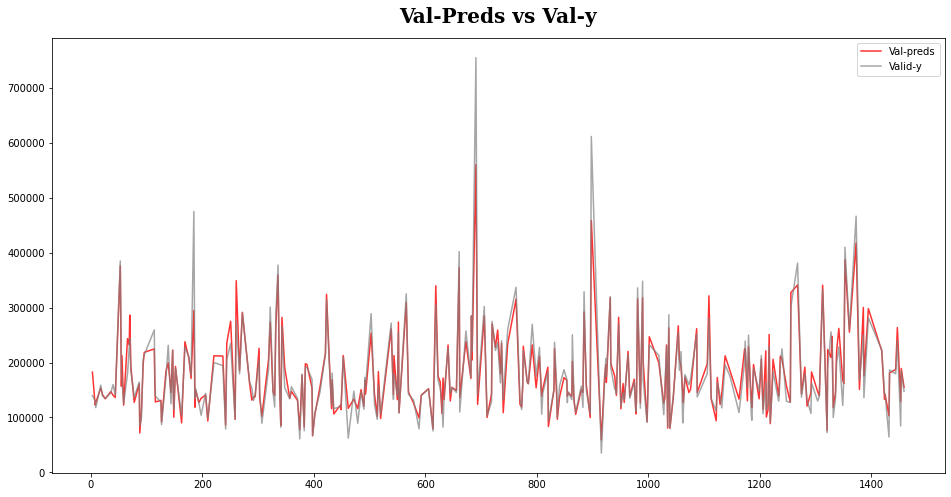

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(preds_cat_Frame.index, preds_cat_Frame, label='Val-preds', color='red', alpha=.8)
plt.plot(Y_valid.index, Y_valid, label='Valid-y', color='gray', alpha=0.7)
plt.legend()
plt.title('Val-Preds vs Val-y', size=20, fontweight='bold', fontfamily='serif', pad=15)

<AxesSubplot:>

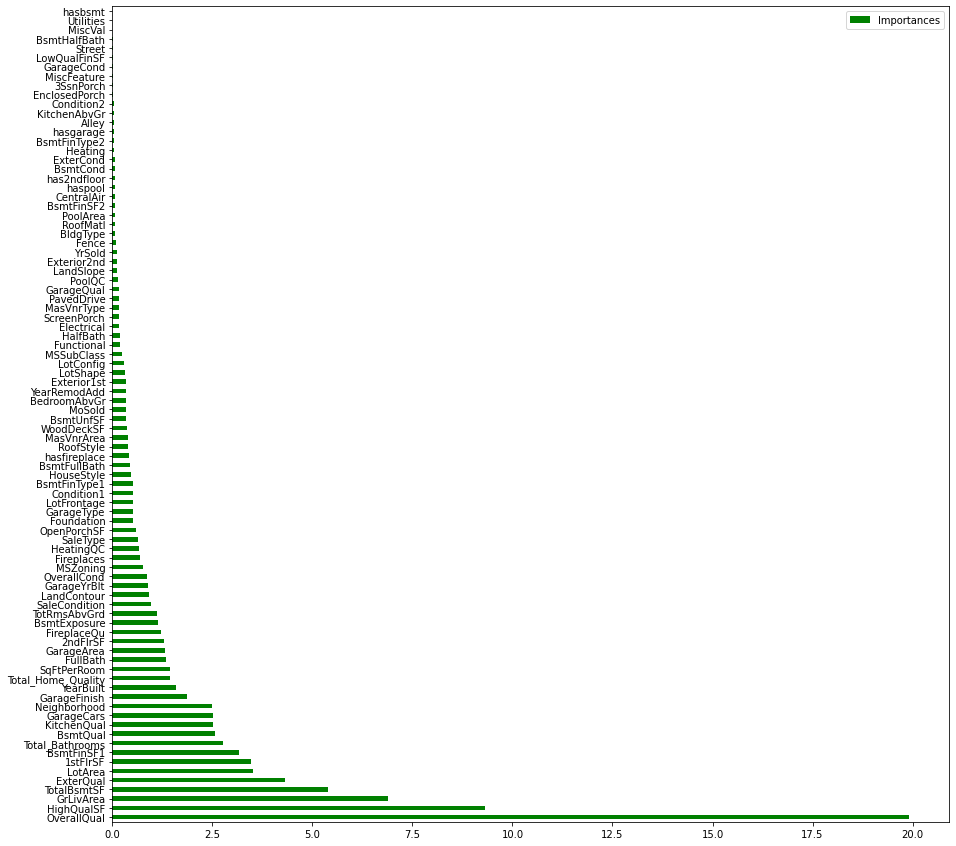

In [ ]:
pd.DataFrame(model.get_feature_importance(), index = X_train.columns).rename(columns={0:'Importances'}).sort_values('Importances', ascending=False).plot.barh(figsize=(15,15), color='green')

In [ ]:
importances_cat = pd.DataFrame(model.get_feature_importance(), index = X_train.columns).rename(columns={0:'Importances'}).sort_values('Importances', ascending=False)

feature_imp_drop = importances_cat.loc[importances_cat['Importances'] < 0.01].index

x_train = x_train.drop(columns=feature_imp_drop)
x_test = x_test.drop(columns=feature_imp_drop)

In [ ]:
predicts = pd.Series(dtypes=np.float)

predicts = predicts.append(model.predict(X_valid))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
cat_features = x_train.select_dtypes('object').columns
preds_cat = np.zeros((len(x_test)))

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
    X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
    Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    model=catboost.CatBoostRegressor(n_estimators=5000, eval_metric='RMSE', use_best_model=True )
    
    model.fit(X_train, Y_train, cat_features=cat_features, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=50)
    
    preds_cat_valid = model.predict(X_valid)
    RMSE = np.sqrt(mean_squared_error(Y_valid, preds_cat_valid))
    print(f'{i+1}Fold RMSE:{RMSE}')
    
    preds_cat = model.predict(x_test) / skf.n_splits

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Learning rate set to 0.017409
0:	learn: 79309.7999907	test: 79306.4341414	test1: 75176.0085009	best: 75176.0085009 (0)	total: 29.5ms	remaining: 2m 27s
100:	learn: 35292.0608492	test: 35059.7351783	test1: 36130.0528856	best: 36130.0528856 (100)	total: 2.76s	remaining: 2m 13s
200:	learn: 24293.2269066	test: 24129.4166572	test1: 30312.9936088	best: 30312.9936088 (200)	total: 5.58s	remaining: 2m 13s
300:	learn: 20640.2110316	test: 20630.3873431	test1: 29214.9189224	best: 29214.9189224 (300)	total: 8.67s	remaining: 2m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 29119.32664
bestIteration = 328

Shrink model to first 329 iterations.
1Fold RMSE:29119.326639126717
Learning rate set to 0.017409
0:	learn: 79510.9144220	test: 79509.5870463	test1: 74089.6276901	best: 74089.6276901 (0)	total: 28.8ms	remaining: 2m 23s
100:	learn: 35218.1334087	test: 34927.1108012	test1: 37794.1958795	best: 37794.1958795 (100)	total: 2.73s	remaining: 2m 12s
200:	learn: 24466.6696372	test: 242

# Stacking Ver.

In [ ]:
import lightgbm as lgbm
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, robust_scale
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from mlxtend.regressor import StackingCVRegressor

In [ ]:
data_for_lgbxgb = data.copy()

for i in data_for_lgbxgb.select_dtypes('object').columns:
    data_for_lgbxgb = pd.get_dummies(data=data_for_lgbxgb, columns=[i])

In [ ]:
x_train = data_for_lgbxgb.loc[data_for_lgbxgb['SalePrice'].notnull()].drop(columns=['Id', 'SalePrice'])
y_train = data_for_lgbxgb.loc[data_for_lgbxgb['SalePrice'].notnull()]['SalePrice']
x_test = data_for_lgbxgb.loc[data_for_lgbxgb['SalePrice'].isnull()].drop(columns=['Id', 'SalePrice'])

x_train.shape, y_train.shape, x_test.shape

((1460, 350), (1460,), (1459, 350))

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, train_labels):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=10))
    return (rmse)

In [ ]:
lightgbm = lgbm.LGBMRegressor(objective='regression',
                       learning_rate=0.01, 
                       n_estimators=7000,
                       random_state=42)

# XGBoost Regressor
xgboost = xgb.XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       random_state=42)



# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=3000,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

cat = catboost.CatBoostRegressor(n_estimators=3000, random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, rf, model),
                                meta_regressor=model,
                                use_features_in_secondary=True)

In [ ]:
scores = {}

score = cv_rmse(lightgbm, x_train, y_train)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 28719.9690 (6336.7246)


In [ ]:
score = cv_rmse(xgboost, x_train, y_train)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

xgboost: 26847.0287 (7021.1434)


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [ ]:
score = cv_rmse(rf, x_train, y_train)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 28755.1638 (6811.1003)


In [ ]:
score = cv_rmse(cat, x_train, y_train)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['cat'] = (score.mean(), score.std())

NameError: name 'cv_rmse' is not defined

In [ ]:
def train(clf, x_train, y_train, x_test, params):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    preds_val = np.zeros((len(x_train),))
    preds_test = np.zeros((len(x_test), skf.n_splits))
    
    for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
        X_train, X_valid = x_train.iloc[train_index], x_train.iloc[test_index]
        Y_train = y_train.iloc[train_index]
            
        clf.fit(X_train, Y_train)
        
        preds_val[test_index] = clf.predict(X_valid).reshape(-1, 1)
        preds_test[:,i] = clf.predict(x_test) / skf.n_splits
    preds_test_mean = np.mean(preds_test, axis=1).reshape(-1, 1)

    
    return preds_val, preds_test_mean

# optuna

In [ ]:
import optuna
from lightgbm import LGBMClassifier
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error
from optuna.integration import SkoptSampler


def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": trial.suggest_float('learning_rate', 0.0001, 0.2),
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 100, 1000),
        "depth": trial.suggest_int("depth", 1, 10),
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
    cat_features = x_train.select_dtypes('object').columns
    preds_cat = np.zeros((len(x_test)))
    
    for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
        X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
        Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
        model=catboost.CatBoostRegressor(n_estimators=3000, eval_metric='RMSE', use_best_model=True, **params_cat)
    
        model.fit(X_train, Y_train, cat_features=cat_features, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=50)
    
        preds_cat = model.predict(X_valid) / skf.n_splits
        RMSE=np.sqrt(mean_squared_error(Y_valid, preds_cat))
        print(RMSE)
        
    return RMSE

In [ ]:
sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(
    study_name="cat_parameter_opt",
    direction="minimize"
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-06-03 05:00:27,188] A new study created in memory with name: cat_parameter_opt
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 79004.9027219	test: 79004.9027219	test1: 74893.5815800	best: 74893.5815800 (0)	total: 12ms	remaining: 35.8s
100:	learn: 32030.6228909	test: 31746.0160252	test1: 35104.2411873	best: 35104.2411873 (100)	total: 851ms	remaining: 24.4s
200:	learn: 24836.0376184	test: 24584.6294379	test1: 31939.7525476	best: 31939.7525476 (200)	total: 1.65s	remaining: 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 31872.12614
bestIteration = 202

Shrink model to first 203 iterations.
159036.95382395724
0:	learn: 79178.7848723	test: 79178.7848723	test1: 73795.6993894	best: 73795.6993894 (0)	total: 9.29ms	remaining: 27.9s
100:	learn: 32643.6605832	test: 32476.9705540	test1: 36262.5299487	best: 36262.5299487 (100)	total: 813ms	remaining: 23.3s
200:	learn: 25740.8747034	test: 25496.4483573	test1: 31678.9135106	best: 31653.6178772 (199)	total: 1.61s	remaining: 22.5s
300:	learn: 22775.7383317	test: 22576.4367535	test1: 30745.6629684	best: 30745.6629684 (300)	total: 2.41s	remaining:

[I 2021-06-03 05:01:09,771] Trial 0 finished with value: 157746.46249586265 and parameters: {'learning_rate': 0.027068617020839916, 'min_data_in_leaf': 482, 'depth': 3}. Best is trial 0 with value: 157746.46249586265.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 28439.36043
bestIteration = 1906

Shrink model to first 1907 iterations.
157746.46249586265
0:	learn: 77125.3949072	test: 77125.3949072	test1: 73118.1306698	best: 73118.1306698 (0)	total: 25.9ms	remaining: 1m 17s


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


100:	learn: 19881.9018253	test: 20117.8890732	test1: 32796.3930582	best: 32533.4170234 (76)	total: 2.52s	remaining: 1m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 32533.41702
bestIteration = 76

Shrink model to first 77 iterations.
158993.3394838509
0:	learn: 77639.9522165	test: 77639.9522165	test1: 72420.4562232	best: 72420.4562232 (0)	total: 26.3ms	remaining: 1m 18s
100:	learn: 19963.0885915	test: 20047.9117954	test1: 27934.7623694	best: 27934.7623694 (100)	total: 2.49s	remaining: 1m 11s
200:	learn: 15779.6414475	test: 16337.9318348	test1: 26253.4864053	best: 26250.4810646 (199)	total: 5.31s	remaining: 1m 13s
300:	learn: 13644.5350270	test: 14733.5355418	test1: 25681.6402498	best: 25680.9161937 (299)	total: 8.06s	remaining: 1m 12s
400:	learn: 11944.5370689	test: 13346.2125837	test1: 25304.6718966	best: 25304.6718966 (400)	total: 10.8s	remaining: 1m 9s
500:	learn: 10617.8586566	test: 12315.3596137	test1: 25099.9470932	best: 25091.8968788 (482)	total: 13.5s	re

[I 2021-06-03 05:02:01,837] Trial 1 finished with value: 157772.29710010331 and parameters: {'learning_rate': 0.06110434378301434, 'min_data_in_leaf': 182, 'depth': 6}. Best is trial 0 with value: 157746.46249586265.


500:	learn: 9869.9524624	test: 11725.6290597	test1: 27692.3427654	best: 27645.2423813 (454)	total: 13.8s	remaining: 1m 8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 27645.24238
bestIteration = 454

Shrink model to first 455 iterations.
157772.29710010331


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 77365.0136339	test: 77366.3809632	test1: 73316.1175203	best: 73316.1175203 (0)	total: 73.3ms	remaining: 3m 39s
100:	learn: 18005.8291362	test: 18884.4919380	test1: 31766.2899228	best: 31766.2899228 (100)	total: 6.83s	remaining: 3m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 31400.21287
bestIteration = 135

Shrink model to first 136 iterations.
158828.85104651644
0:	learn: 77792.2401590	test: 77792.2401590	test1: 72518.2948763	best: 72518.2948763 (0)	total: 53.7ms	remaining: 2m 40s
100:	learn: 18518.1217204	test: 19337.3336093	test1: 30254.2008536	best: 30254.2008536 (100)	total: 6.25s	remaining: 2m 59s
200:	learn: 13336.6517634	test: 15010.4976302	test1: 28480.8530818	best: 28480.8530818 (200)	total: 13.3s	remaining: 3m 5s
300:	learn: 10548.5877655	test: 12922.2045321	test1: 27765.7403075	best: 27765.7403075 (300)	total: 20.7s	remaining: 3m 5s
400:	learn: 8669.5632524	test: 11503.4722981	test1: 27564.9701890	best: 27563.2492731 (399)	total: 28.2s	rem

[I 2021-06-03 05:05:12,513] Trial 2 finished with value: 157736.09363865963 and parameters: {'learning_rate': 0.05658521655752059, 'min_data_in_leaf': 572, 'depth': 8}. Best is trial 2 with value: 157736.09363865963.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 28132.11918
bestIteration = 571

Shrink model to first 572 iterations.
157736.09363865963
0:	learn: 77428.6416291	test: 77428.6416291	test1: 73300.5156801	best: 73300.5156801 (0)	total: 14.2ms	remaining: 42.4s


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


100:	learn: 22423.5870615	test: 22442.6229636	test1: 32907.1928289	best: 32907.1928289 (100)	total: 1.23s	remaining: 35.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 32727.45737
bestIteration = 104

Shrink model to first 105 iterations.
159022.02275463927
0:	learn: 77655.1591930	test: 77655.1591930	test1: 72436.7956485	best: 72436.7956485 (0)	total: 13.5ms	remaining: 40.4s
100:	learn: 22720.7246954	test: 22493.2877578	test1: 28474.1161232	best: 28474.1161232 (100)	total: 1.23s	remaining: 35.3s
200:	learn: 18829.1922223	test: 18762.7665589	test1: 26687.5346083	best: 26687.5346083 (200)	total: 2.47s	remaining: 34.4s
300:	learn: 16946.0563975	test: 17190.4859317	test1: 26123.0633545	best: 26108.0565633 (293)	total: 3.74s	remaining: 33.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 26007.76101
bestIteration = 327

Shrink model to first 328 iterations.
155913.23379243587
0:	learn: 74409.7428839	test: 74409.7428839	test1: 84635.7432673	best: 84635

[I 2021-06-03 05:05:44,079] Trial 3 finished with value: 157564.98059731635 and parameters: {'learning_rate': 0.060291540905741986, 'min_data_in_leaf': 360, 'depth': 4}. Best is trial 3 with value: 157564.98059731635.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 26710.75036
bestIteration = 748

Shrink model to first 749 iterations.
157564.98059731635
0:	learn: 79657.6029133	test: 79657.6029133	test1: 75559.7501366	best: 75559.7501366 (0)	total: 9.89ms	remaining: 29.7s


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


100:	learn: 45098.4374045	test: 44987.3448979	test1: 42781.5210527	best: 42781.5210527 (100)	total: 823ms	remaining: 23.6s
200:	learn: 33025.7473366	test: 32843.4342456	test1: 35106.0466467	best: 35106.0466467 (200)	total: 1.63s	remaining: 22.7s
300:	learn: 27995.8633335	test: 27752.7103582	test1: 33166.9749830	best: 33159.5639931 (299)	total: 2.43s	remaining: 21.8s
400:	learn: 25355.8768556	test: 25142.2681571	test1: 32409.9042264	best: 32324.5862488 (391)	total: 3.24s	remaining: 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 32217.02251
bestIteration = 449

Shrink model to first 450 iterations.
159074.16452884945
0:	learn: 79887.5328231	test: 79887.5328231	test1: 74421.2531866	best: 74421.2531866 (0)	total: 9.35ms	remaining: 28s
100:	learn: 45078.0740653	test: 44965.6445891	test1: 45145.8850775	best: 45145.8850775 (100)	total: 813ms	remaining: 23.3s
200:	learn: 33652.8807816	test: 33456.1594032	test1: 36652.9029116	best: 36652.9029116 (200)	total: 1.61s	remaini

[I 2021-06-03 05:06:42,319] Trial 4 finished with value: 157674.5940259746 and parameters: {'learning_rate': 0.0124437755441306, 'min_data_in_leaf': 747, 'depth': 3}. Best is trial 3 with value: 157564.98059731635.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 28799.3665
bestIteration = 1896

Shrink model to first 1897 iterations.
157674.5940259746
0:	learn: 78201.9485413	test: 78201.9485413	test1: 74079.6987083	best: 74079.6987083 (0)	total: 2.44ms	remaining: 7.33s


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


100:	learn: 33279.5536297	test: 33192.4902790	test1: 35517.6159280	best: 35479.6620615 (99)	total: 125ms	remaining: 3.59s
200:	learn: 27796.5542763	test: 27644.8382446	test1: 33041.9034338	best: 33041.9034338 (200)	total: 240ms	remaining: 3.33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 32870.96724
bestIteration = 239

Shrink model to first 240 iterations.
159128.99913747745
0:	learn: 78363.4984813	test: 78363.4984813	test1: 73271.2808541	best: 73271.2808541 (0)	total: 2.27ms	remaining: 6.82s
100:	learn: 33179.6430784	test: 33116.8635019	test1: 35819.3574761	best: 35819.3574761 (100)	total: 114ms	remaining: 3.28s
200:	learn: 28225.1116429	test: 28163.4597327	test1: 33259.7759723	best: 33259.7759723 (200)	total: 223ms	remaining: 3.11s
300:	learn: 26191.7255946	test: 26526.4316322	test1: 32736.4103584	best: 32684.6612406 (278)	total: 337ms	remaining: 3.03s
400:	learn: 24837.5529542	test: 25481.4697790	test1: 32039.4245806	best: 32032.2013328 (387)	total: 451ms	rema

[I 2021-06-03 05:06:48,283] Trial 5 finished with value: 157779.04959643164 and parameters: {'learning_rate': 0.05679096133862636, 'min_data_in_leaf': 816, 'depth': 1}. Best is trial 3 with value: 157564.98059731635.


2000:	learn: 20724.2212889	test: 20743.5646544	test1: 30090.1826072	best: 30043.8514965 (1969)	total: 2.62s	remaining: 1.31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 30043.8515
bestIteration = 1969

Shrink model to first 1970 iterations.
157779.04959643164


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 76173.3342446	test: 76177.4578584	test1: 72191.3930695	best: 72191.3930695 (0)	total: 121ms	remaining: 6m 4s
100:	learn: 14365.5927793	test: 15943.3090995	test1: 27938.0658867	best: 27938.0658867 (100)	total: 11.2s	remaining: 5m 20s
200:	learn: 8800.3744394	test: 11541.1653758	test1: 27475.1132668	best: 27454.5502248 (195)	total: 22.8s	remaining: 5m 18s
300:	learn: 6171.9095707	test: 9826.7633922	test1: 27398.0939495	best: 27358.8121558 (264)	total: 35.1s	remaining: 5m 15s
400:	learn: 4406.0408680	test: 8814.8886706	test1: 27213.1976211	best: 27209.9602357 (395)	total: 48.2s	remaining: 5m 12s
500:	learn: 3325.2756450	test: 8255.0218391	test1: 27162.9832771	best: 27162.9832771 (500)	total: 1m	remaining: 5m 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 27151.8018
bestIteration = 546

Shrink model to first 547 iterations.
158732.23295700745
0:	learn: 76718.4310773	test: 76722.3700644	test1: 71699.3866047	best: 71699.3866047 (0)	total: 84.2ms	remaining: 4m 

[I 2021-06-03 05:11:58,961] Trial 6 finished with value: 158342.36810112747 and parameters: {'learning_rate': 0.08284082467679958, 'min_data_in_leaf': 596, 'depth': 9}. Best is trial 3 with value: 157564.98059731635.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 32504.16646
bestIteration = 594

Shrink model to first 595 iterations.
158342.36810112747


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 74190.4918285	test: 74193.4337319	test1: 70206.7735311	best: 70206.7735311 (0)	total: 55.9ms	remaining: 2m 47s
100:	learn: 13061.9859832	test: 14577.2313506	test1: 29095.8817321	best: 29063.2247292 (86)	total: 6.29s	remaining: 3m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 28803.72954
bestIteration = 124

Shrink model to first 125 iterations.
158897.3714148179
0:	learn: 74777.8403400	test: 74777.8403400	test1: 69815.9579454	best: 69815.9579454 (0)	total: 51ms	remaining: 2m 32s
100:	learn: 12815.8942452	test: 14209.6000706	test1: 29813.3151793	best: 29813.3151793 (100)	total: 6.46s	remaining: 3m 5s
200:	learn: 8521.1345526	test: 11025.8472260	test1: 29390.1063990	best: 29390.1063990 (200)	total: 14.1s	remaining: 3m 15s
300:	learn: 5849.2680446	test: 9210.4043314	test1: 29306.6946445	best: 29306.6946445 (300)	total: 21.5s	remaining: 3m 12s
400:	learn: 4120.3568112	test: 8260.4281714	test1: 29245.5763975	best: 29245.5763975 (400)	total: 29s	remaining: 3m 7s

[I 2021-06-03 05:13:59,167] Trial 7 finished with value: 157835.6288402737 and parameters: {'learning_rate': 0.12076705364075903, 'min_data_in_leaf': 425, 'depth': 8}. Best is trial 3 with value: 157564.98059731635.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 28710.01362
bestIteration = 191

Shrink model to first 192 iterations.
157835.6288402737
0:	learn: 73409.4038508	test: 73409.4038508	test1: 69235.0666941	best: 69235.0666941 (0)	total: 13.7ms	remaining: 41.1s


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Stopped by overfitting detector  (50 iterations wait)

bestTest = 33625.06286
bestIteration = 28

Shrink model to first 29 iterations.
159009.11441171134
0:	learn: 73550.3734489	test: 73550.3734489	test1: 68823.4709384	best: 68823.4709384 (0)	total: 14.1ms	remaining: 42.4s
100:	learn: 18213.1043509	test: 18393.0550518	test1: 28525.8073910	best: 28483.4223901 (99)	total: 1.26s	remaining: 36.2s
200:	learn: 14624.5445876	test: 15321.7803150	test1: 27890.9211349	best: 27788.9819635 (175)	total: 2.52s	remaining: 35.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 27788.98196
bestIteration = 175

Shrink model to first 176 iterations.
155764.61365448518
0:	learn: 70344.9911730	test: 70344.9911730	test1: 80133.2184759	best: 80133.2184759 (0)	total: 13.5ms	remaining: 40.4s
100:	learn: 16847.7512936	test: 17057.2241832	test1: 27740.9078225	best: 27729.5759661 (97)	total: 1.26s	remaining: 36.1s
200:	learn: 13360.8396400	test: 13813.5867171	test1: 27590.5755776	best: 27557.2091

[I 2021-06-03 05:14:16,258] Trial 8 finished with value: 157267.64901039648 and parameters: {'learning_rate': 0.15017762185500286, 'min_data_in_leaf': 269, 'depth': 4}. Best is trial 8 with value: 157267.64901039648.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 27285.67098
bestIteration = 475

Shrink model to first 476 iterations.
157267.64901039648
0:	learn: 77964.7485628	test: 77964.7485628	test1: 73934.1595386	best: 73934.1595386 (0)	total: 26ms	remaining: 1m 17s


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


100:	learn: 22401.8887375	test: 22508.3611749	test1: 32567.5501551	best: 32567.5501551 (100)	total: 2.8s	remaining: 1m 20s
200:	learn: 17323.5524613	test: 17889.4279341	test1: 32479.9421448	best: 32233.3899944 (161)	total: 5.19s	remaining: 1m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 32233.38999
bestIteration = 161

Shrink model to first 162 iterations.
158774.19920760737
0:	learn: 78415.4135037	test: 78415.4135037	test1: 73108.1256422	best: 73108.1256422 (0)	total: 24.8ms	remaining: 1m 14s
100:	learn: 22739.8584655	test: 22608.0359564	test1: 31003.3131936	best: 30994.5180896 (98)	total: 2.5s	remaining: 1m 11s
200:	learn: 17905.7948698	test: 18090.4485743	test1: 28119.1426418	best: 28119.1426418 (200)	total: 5.04s	remaining: 1m 10s
300:	learn: 15209.8851504	test: 15794.4207970	test1: 26999.1752275	best: 26991.2378273 (299)	total: 8.43s	remaining: 1m 15s
400:	learn: 13631.4786109	test: 14452.9614181	test1: 26793.3028409	best: 26782.6675703 (398)	total: 11.1s	

[I 2021-06-03 05:15:48,083] Trial 9 finished with value: 157723.98890480684 and parameters: {'learning_rate': 0.044394615080020766, 'min_data_in_leaf': 813, 'depth': 6}. Best is trial 8 with value: 157267.64901039648.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 27980.95403
bestIteration = 829

Shrink model to first 830 iterations.
157723.98890480684
Best Score: 157267.64901039648
Best trial: {'learning_rate': 0.15017762185500286, 'min_data_in_leaf': 269, 'depth': 4}


In [ ]:
submission['SalePrice'] = preds_cat
submission.to_csv('submission8.csv', index=False)
submission

,Id,SalePrice
0,1461,24584.435589
1,1462,30698.163494
2,1463,35752.692175
3,1464,37203.811819
4,1465,39149.059918
...,...,...
1454,2915,17554.154654
1455,2916,17001.877603
1456,2917,31258.041674
1457,2918,23768.368432
